# Project 

This is the project for course EE4540 Distributed Signal Processing.

Environment:

Python = 3.12

## Initialization

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import time
import random
from math import log, pi, ceil
from scipy.spatial import distance_matrix
from scipy.optimize import fsolve
from scipy.sparse.csgraph import laplacian

In [2]:
# set seed
np.random.seed(42)
random.seed(42)

# define the situation
Area_Length = 100 # the length of the area, both length and width are the same
Area_Size = Area_Length ** 2

## Q1 Sensor deployment

In [3]:
# Definition of expected coverage rate and connection probability
Area_Coverage = 0.999 # Define the total coverage rate of the sensors
Connected_Prob = 0.99


In [4]:
# Known r, calculate n

'''
Poisson point process model: 
p = 1 - e^(−𝑛𝜋𝑟^2/A)   ->   n = -ln(1-p) * A / 𝜋r^2
p >= required coverage rate   ->   n >= -ln(1-required coverage rate) * A / 𝜋r^2
'''
def nodes_for_coverage(area_size, Comm_Radius, coverage_required):
    return ceil(-area_size * np.log(1 - coverage_required) / (pi * Comm_Radius ** 2))


'''
Minimum amount of sensors according to RGG: 
r^d >= (2 * ln(n)) / n
then connected with probability p >= 1 - 1/n^2
'''
def nodes_for_connectivity(normalized_radius, dimension, probability):
    def equation(n_array):
        # This is the equation for RGG
        return (2 * np.log(n_array[0])) / n_array[0] - normalized_radius ** dimension

    n_array = [10.0]
    n_connectivity = fsolve(equation, n_array)  # Calculation the equation equals to 0, n_array is a start point
    n_prob = ceil(np.sqrt(1 / (1 - probability))) # Consider the probability of connection

    return max(int(ceil(n_connectivity[0])), n_prob)


def nodes_final (Comm_Radius):
    # Calculate number of nodes
    n_coverage = nodes_for_coverage(Area_Size, Comm_Radius, Area_Coverage)
    print(f"Minimum sensors required for coverage: {n_coverage}")
    n_connectivity = nodes_for_connectivity(Comm_Radius / Area_Length, dimension=2, probability=Connected_Prob)
    print(f"Minimum sensors required for connectivity: {n_connectivity}")
    n_final = max(n_connectivity, n_coverage)
    print(f"Final number of sensors used: {n_final}")

    # Random place the sensors
    sensor_location = np.random.uniform(0, Area_Length, (n_final, 2))

    # Calculate Euclidean distance matrix
    Euc_matrix = distance_matrix(sensor_location, sensor_location)

    # Calculate adjacency matrix
    adj_matrix = (Euc_matrix <= Comm_Radius) & (Euc_matrix > 0)

    # Build network graph
    Graphs = nx.Graph()
    for i in range(n_final):
        Graphs.add_node(i, pos=tuple(sensor_location[i]))

    for j in range(n_final):
        for k in range(j + 1, n_final):
            if adj_matrix[j, k]:
                Graphs.add_edge(j, k)
    return(Graphs, n_final, sensor_location)

Minimum sensors required for coverage: 880
Minimum sensors required for connectivity: 7094
Final number of sensors used: 7094
The graph is connected
Minimum sensors required for coverage: 220
Minimum sensors required for connectivity: 1457
Final number of sensors used: 1457
The graph is connected
Minimum sensors required for coverage: 98
Minimum sensors required for connectivity: 563
Final number of sensors used: 563
The graph is connected
Minimum sensors required for coverage: 55
Minimum sensors required for connectivity: 283
Final number of sensors used: 283
The graph is connected
Minimum sensors required for coverage: 36
Minimum sensors required for connectivity: 164
Final number of sensors used: 164
The graph is connected
Minimum sensors required for coverage: 25
Minimum sensors required for connectivity: 103
Final number of sensors used: 103
The graph is connected
Minimum sensors required for coverage: 18
Minimum sensors required for connectivity: 70
Final number of sensors used: 

C:\Users\nemuru\AppData\Local\Temp\ipykernel_33548\4195702081.py:20: RuntimeWarning: invalid value encountered in log
  return (2 * np.log(n_array[0])) / n_array[0] - normalized_radius ** dimension
C:\Users\nemuru\AppData\Local\Temp\ipykernel_33548\4195702081.py:23: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  n_connectivity = fsolve(equation, n_array)  # Calculation the equation equals to 0, n_array is a start point


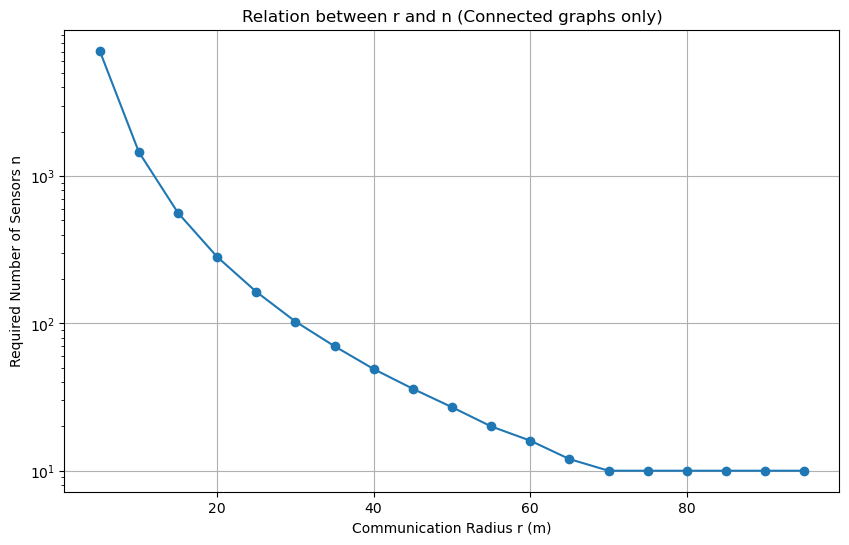

In [5]:
# iterate for different r
r_values = []
n_values = []
connected_count = 0
disconnected_count = 0
for Comm_Radius in range(5, 100, 5):
    Graphs, n_final,_ = nodes_final(Comm_Radius)
    connection_state = nx.is_connected(Graphs) # Check connectivity

    if connection_state:
        print("The graph is connected")
        connected_count += 1
        r_values.append(Comm_Radius)
        n_values.append(n_final)
    else:
        print("The graph is not connected")

print(f"Connected graphs: {connected_count}")
print(f"Disconnected graphs: {disconnected_count}")

# Plot r vs n
plt.figure(figsize=(10, 6))
plt.plot(r_values, n_values, marker='o')
plt.xlabel("Communication Radius r (m)")
plt.ylabel("Required Number of Sensors n")
plt.yscale('log')
plt.title("Relation between r and n (Connected graphs only)")
plt.grid(True)
plt.show()


Minimum sensors required for coverage: 9
Minimum sensors required for connectivity: 27
Final number of sensors used: 27
The graph is connected


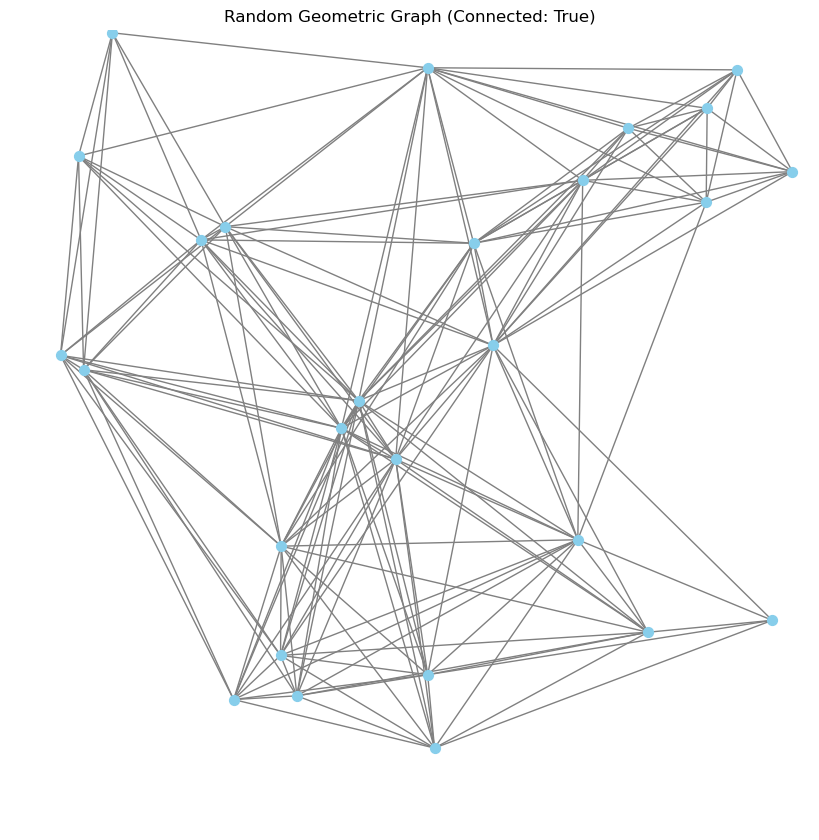

In [6]:
# get n from r
Comm_Radius = input("Please input the communication Radius r (m):") # the result is from r = 50

Graphs, n_final, sensor_location = nodes_final(int(Comm_Radius))
connection_state = nx.is_connected(Graphs)

if connection_state:
    print("The graph is connected")
else:
    print("The graph is not connected")

# Visualize the graph
pos_dict = {i: sensor_location[i] for i in range(n_final)}
plt.figure(figsize=(8, 8))
nx.draw(Graphs, pos=pos_dict, node_size=50, with_labels=False,
        node_color='skyblue', edge_color='gray')
plt.title(f"Random Geometric Graph (Connected: {connection_state})")
plt.grid(True)
plt.xlim(0, Area_Length)
plt.ylim(0, Area_Length)
plt.show()


In [7]:
# Known n, calculate r

def radius_for_coverage(number_nodes):
    r_cov = np.sqrt(-Area_Size * log(1 - Area_Coverage) / (pi * number_nodes))
    maximum_radius = Area_Length * np.sqrt(2)
    if r_cov > maximum_radius:
        return maximum_radius
    else:
        return r_cov


def radius_for_connectivity(number_nodes):
    if (1 - 1/(number_nodes **2)) < Connected_Prob:
        maximum_radius = Area_Length * np.sqrt(2)
        return maximum_radius
    else:
        r_conn = Area_Length * np.sqrt(2 * log(number_nodes)/number_nodes)
        return r_conn


def radius_final(number_nodes):
    r_coverage = radius_for_coverage(number_nodes)
    print(f"Minimum radius required for coverage: {r_coverage}")
    r_connectivity = radius_for_connectivity(number_nodes)
    print(f"Minimum radius of sensors required for connectivity: {r_connectivity}")
    r_final = max(r_connectivity, r_coverage)
    print(f"Final radius of sensors used: {r_final}")

    # Random place the sensors
    sensor_location = np.random.uniform(0, Area_Length, (number_nodes, 2))

    # Calculate Euclidean distance matrix
    Euc_matrix = distance_matrix(sensor_location, sensor_location)

    # Calculate adjacency matrix
    adj_matrix = (Euc_matrix <= r_final) & (Euc_matrix > 0)

    # Build network graph
    Graphs = nx.Graph()
    for i in range(number_nodes):
        Graphs.add_node(i, pos=tuple(sensor_location[i]))

    for j in range(number_nodes):
        for k in range(j + 1, number_nodes):
            if adj_matrix[j, k]:
                Graphs.add_edge(j, k)
    
    return(Graphs, r_final, sensor_location)


The number of nodes: 1
Minimum radius required for coverage: 141.4213562373095
Minimum radius of sensors required for connectivity: 141.4213562373095
Final radius of sensors used: 141.4213562373095
The graph is connected
The number of nodes: 2
Minimum radius required for coverage: 104.85243909033025
Minimum radius of sensors required for connectivity: 141.4213562373095
Final radius of sensors used: 141.4213562373095
The graph is connected
The number of nodes: 4
Minimum radius required for coverage: 74.14187070472195
Minimum radius of sensors required for connectivity: 141.4213562373095
Final radius of sensors used: 141.4213562373095
The graph is connected
The number of nodes: 6
Minimum radius required for coverage: 60.53658393399101
Minimum radius of sensors required for connectivity: 141.4213562373095
Final radius of sensors used: 141.4213562373095
The graph is connected
The number of nodes: 8
Minimum radius required for coverage: 52.426219545165125
Minimum radius of sensors required 

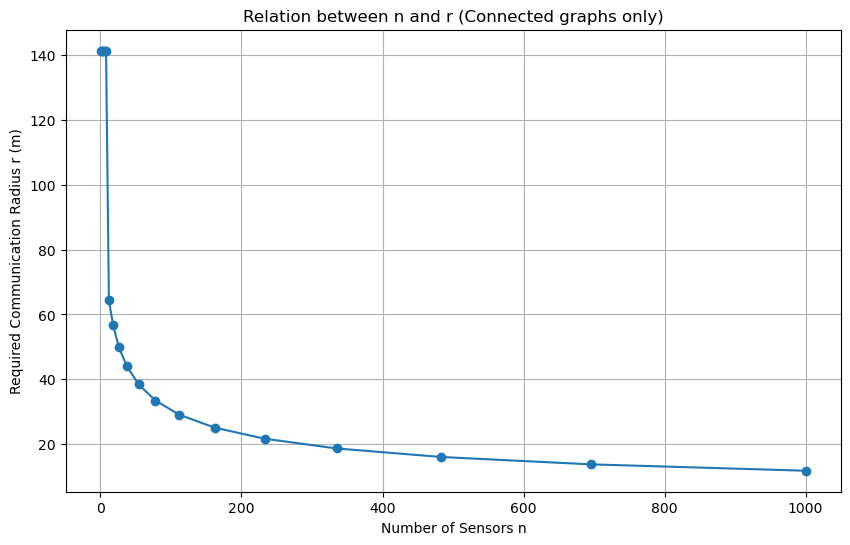

In [8]:
# iterate for different n
r_values = []
n_values = []
connected_count = 0
disconnected_count = 0

log_nodes = np.logspace(0, 3, num=20, dtype=int) # 10^0=1 to 10^3=1000
unique_nodes = sorted(list(set(log_nodes))) # remove duplicates and sort
for number_nodes in unique_nodes:
    print(f"The number of nodes: {number_nodes}")
    Graphs, r_final,_ = radius_final(number_nodes)
    connection_state = nx.is_connected(Graphs) # Check connectivity

    if connection_state:
        print("The graph is connected")
        connected_count += 1
        r_values.append(r_final)
        n_values.append(number_nodes)
    else:
        print("The graph is not connected")

print(f"Connected graphs: {connected_count}")
print(f"Disconnected graphs: {disconnected_count}")

# Plot r vs n
plt.figure(figsize=(10, 6))
plt.plot(n_values, r_values, marker='o')
plt.xlabel("Number of Sensors n")
plt.ylabel("Required Communication Radius r (m)")
#plt.yscale('log')
plt.title("Relation between n and r (Connected graphs only)")
plt.grid(True)
plt.show()


Minimum radius required for coverage: 20.97048781806605
Minimum radius of sensors required for connectivity: 39.55766932177954
Final radius of sensors used: 39.55766932177954
The graph is connected


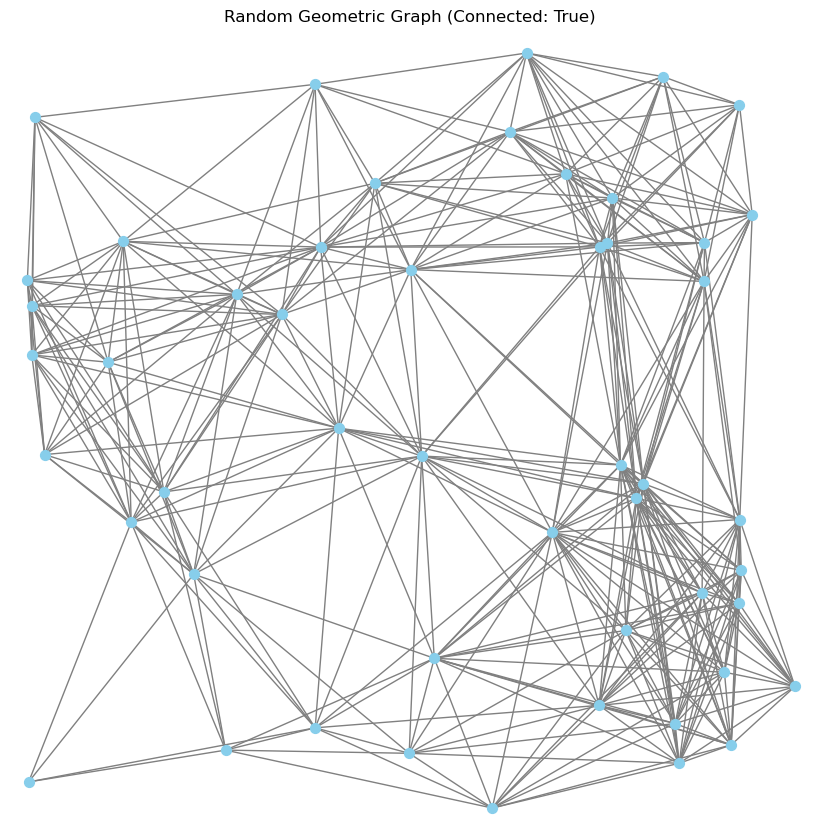

In [9]:
# get r from n
number_nodes = input("Please input the number of sensors:") # the result is from n = 50

Graphs, r_final, sensor_location = radius_final(int(number_nodes))
connection_state = nx.is_connected(Graphs)
if connection_state:
    print("The graph is connected")
else:
    print("The graph is not connected")

# Visualize the graph
pos_dict = {i: sensor_location[i] for i in range(int(number_nodes))}
plt.figure(figsize=(8, 8))
nx.draw(Graphs, pos=pos_dict, node_size=50, with_labels=False,
        node_color='skyblue', edge_color='gray')
plt.title(f"Random Geometric Graph (Connected: {connection_state})")
plt.grid(True)
plt.xlim(0, Area_Length)
plt.ylim(0, Area_Length)
plt.show()

## Generate graph example
for further processing and discussion about distributed algorithm

example: n = 50; r = 40

In [10]:
# Definition of expected coverage rate and connection probability
Area_Coverage = 0.999
Connected_Prob = 0.99

In [11]:
n = 50 # Number of sensors
Comm_Radius = 40 # Communication radius of each sensor

sensor_location = np.random.uniform(0, Area_Length, (n, 2))

# Calculate Euclidean distance matrix
Euc_matrix = distance_matrix(sensor_location, sensor_location)

# Calculate adjacency matrix
adj_matrix = (Euc_matrix <= Comm_Radius) & (Euc_matrix > 0)
print(adj_matrix)

# Build network graph
Graphs = nx.Graph()
for i in range(n):
    Graphs.add_node(i, pos = tuple(sensor_location[i]))

for j in range(n):
    for k in range (j+1, n):
        if adj_matrix[j,k]:
            Graphs.add_edge(j, k)
            
print(f"Network connected: {nx.is_connected(Graphs)}")
print(f"Number of edges: {Graphs.number_of_edges()}")

[[False False False ... False False False]
 [False False False ...  True  True False]
 [False False False ... False False  True]
 ...
 [False  True False ... False False False]
 [False  True False ... False False  True]
 [False False  True ... False  True False]]
Network connected: True
Number of edges: 408


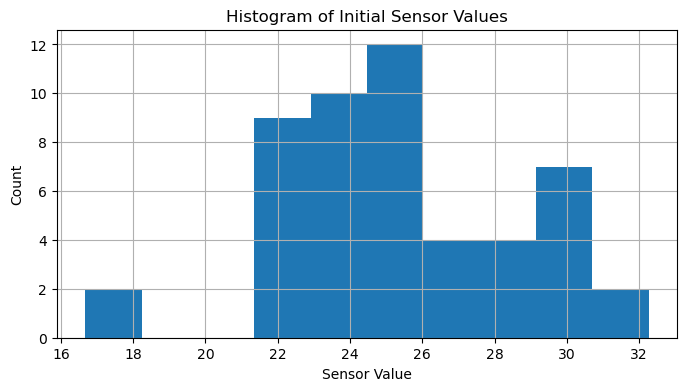

Global average: 25.3792
Global median: 24.9496


In [12]:
# initialize sensor values
# init_values = np.random.uniform(20, 30, n)
init_values = np.random.normal(loc=25, scale=3, size=n)

# plot
plt.figure(figsize=(8, 4))
plt.hist(init_values, bins=10)
plt.xlabel('Sensor Value')
plt.ylabel('Count')
plt.title('Histogram of Initial Sensor Values')
plt.grid(True)
plt.show()

global_avg = np.mean(init_values)
global_median = np.median(init_values)
print(f"Global average: {global_avg:.4f}")
print(f"Global median: {global_median:.4f}")


## Q2 Averaging
### Randomised gossip

In [13]:
# Randomised Gossip Algorithm for distributed average computation
# global_avg is only used for calculate errors and stop condition for plotting
def randomised_gossip(init_values, adj_matrix, global_avg, log_freq=1, max_iterations=5000, threshold=1e-6):
    values = init_values.copy()
    n = len(values)
    
    # initialize history
    history = {
        'errors': [],
        'transmissions': 0,
        'iteration': 0
    }
    
    # initialize
    history['errors'].append(np.sum((values - global_avg) ** 2))
    iteration = 0
    
    while iteration < max_iterations:
        # select a random node
        node_i = random.randint(0, n - 1)
        
        # randomly select a neighbor
        neighbors = [idx for idx, connected in enumerate(adj_matrix[node_i]) if connected]
        if not neighbors:
            continue
        node_j = random.choice(neighbors)
        
        # exchange values between node_i and node_j
        value_i = values[node_i]
        value_j = values[node_j]
        
        # calculate the average of the two nodes
        new_value = (value_i + value_j) / 2.0
        
        # renew the values of both nodes
        values[node_i] = new_value
        values[node_j] = new_value
        
        # record the transmission
        history['transmissions'] += 2 # bi-directional transmission
        iteration += 1
        
        # record the history
        if iteration % log_freq == 0:  # every log_freq iterations record once
            current_error = np.sum((values - global_avg) ** 2)
            history['errors'].append(current_error)
            
            # check whether stop
            if current_error < threshold:
                break
    
    history['iteration'] = iteration

    return values, history


In [14]:
# parameters
log_freq = 1
stop_threshold = 1e-8

# run the randomised gossip algorithm
print("\nRunning randomised gossip algorithm...")
start_time = time.time()
final_rg, history_rg = randomised_gossip(init_values, adj_matrix, global_avg, log_freq=log_freq, threshold=stop_threshold)
elapsed_time = time.time() - start_time

# output the results
final_values = final_rg
final_avg = np.mean(final_values)
final_error = history_rg['errors'][-1] # final error is the last recorded error

print("\nAlgorithm completed!")
print(f"Total iterations: {len(history_rg['errors']) * log_freq}")
print(f"Total transmissions: {history_rg['transmissions']}")
print(f"Execution time: {elapsed_time:.4f} seconds")
print(f"Final estimated average: {final_avg:.8f}")
print(f"Global average: {global_avg:.8f}")
print(f"Absolute error: {abs(final_avg - global_avg):.8f}")
print(f"Squared error: {final_error:.8f}")



Running randomised gossip algorithm...

Algorithm completed!
Total iterations: 3531
Total transmissions: 7060
Execution time: 0.0419 seconds
Final estimated average: 25.37916801
Global average: 25.37916801
Absolute error: 0.00000000
Squared error: 0.00000001


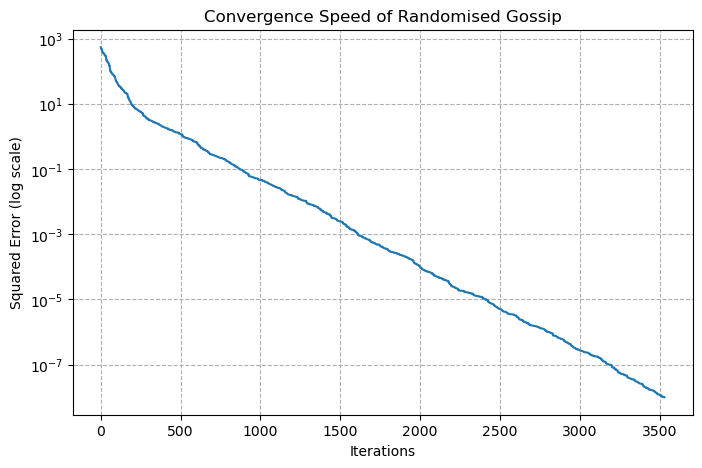

In [15]:
# convergence speed
plt.figure(figsize=(8, 5))
plt.semilogy(np.arange(0, len(history_rg['errors'])) * log_freq, history_rg['errors'])
plt.xlabel('Iterations')
plt.ylabel('Squared Error (log scale)')
plt.title('Convergence Speed of Randomised Gossip')
plt.grid(True, which="both", ls="--")
plt.show()

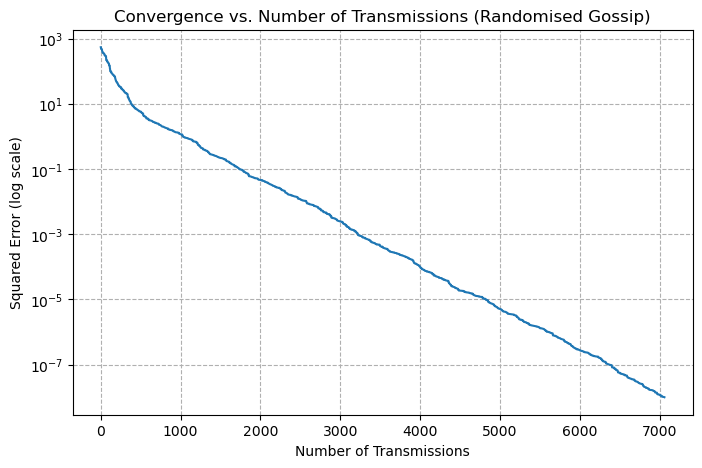

In [16]:
# number of transmissions
plt.figure(figsize=(8, 5))
plt.semilogy(np.arange(0, len(history_rg['errors'])) * log_freq * 2, history_rg['errors'])
plt.xlabel('Number of Transmissions')
plt.ylabel('Squared Error (log scale)')
plt.title('Convergence vs. Number of Transmissions (Randomised Gossip)')
plt.grid(True, which="both", ls="--")
plt.show()

### PDMM

In [17]:
"""
PDMM for the average-consensus problem.

Returns
-------
x : np.ndarray
    Consensus values at each node.
history : dict
    'errors'          squared-error trace ‖x-avg‖² every log_freq iters
    'tx_curve'        cumulative number of scalar transmissions
    'transmissions'   final total transmissions
"""
def pdmm_average_consensus(
        v,               # Local sensor readings a_i
        adj,             # Adjacency matrix (bool 2-D)
        c=0.5,           # PDMM tuning parameter c
        is_unicast=True,  # whether to use unicast or broadcast
        is_synchronous=True,  # synchronous or asynchronous
        active_rate=1.0,  # rate of active nodes in asynchronous mode
        max_iter=5000,
        tol=1e-8,
        log_freq=1,
        verbose=False):
    
    n       = len(v)
    deg     = np.sum(adj, axis=1) # Node degree d_i
    avg     = v.mean()

    # ---------- Initialisation ----------
    # Directed edge set: (i, j) s.t. i ≠ j and adj[i, j] == True
    dir_edges = [(i, j) for i in range(n) for j in range(n)
                 if i != j and adj[i, j]]
    z   = {e: 0.0 for e in dir_edges} # z_{i|j}
    x   = v.copy()

    # ---------- Logging ----------
    err_hist = [np.sum((x - avg) ** 2)]
    tx_hist  = [0]
    transmissions = 0

    # ---------- Main loop ----------
    for k in range(1, max_iter):
        # according to is_synchronous, iterate over all nodes or just some random ones
        if is_synchronous:
            active_nodes = range(n)
        else:
            active_nodes = random.sample(range(n), int(active_rate * n))

        # 1) x-update
        y = {}
        for i in active_nodes:
            edges = [(i, j) for j in range(n) if adj[i, j] and i != j]
            if not edges:
                continue

            s_z = sum(z[edge] for edge in edges)
            x[i] = (v[i] - s_z) / (1 + c * deg[i])

            # 2) y-updates
            for edge in edges:
                y[edge] = z[edge] + 2 * c * x[i] # y_{i|j}^{(k)}

            if is_unicast:
                # Unicast: send y_{i|j} to j
                transmissions += len(edges)
            else:
                # Broadcast: send x_{k} to j
                transmissions += 1

        # 3) z-updates
        for i in active_nodes:
            for j in range(n):
                if i != j and adj[i, j]:
                    z[(j, i)] = -y[(i, j)] # z_{i|j}^{(k+1)}

        # Logging / convergence check
        if k % log_freq == 0:
            err = np.sum((x - avg) ** 2)
            err_hist.append(err)
            tx_hist.append(transmissions)
            if verbose:
                print(f"iter {k:5d} | err = {err:.3e}")
            if err < tol:
                break

    history = {
        'errors': err_hist,
        'tx_curve': tx_hist,
        'transmissions': tx_hist[-1],
        'iteration': k
    }
    
    return x, history

In [18]:
# ------ Parameters ------
c = 0.5
log_freq = 1
stop_threshold = 1e-8

# ------ Run PDMM with timing ------
start_time = time.time()
final_pdmm, history_pdmm = pdmm_average_consensus(init_values, adj_matrix, c=c, log_freq=log_freq, tol=stop_threshold)
elapsed_time = time.time() - start_time

# ------ Postprocessing metrics ------
final_values = final_pdmm
final_avg = np.mean(final_values)
global_avg = np.mean(init_values)
final_error = history_pdmm['errors'][-1]         # last squared error

# ------ Output results ------
print("\nAlgorithm completed!")
print(f"Total iterations: {len(history_pdmm['errors']) * log_freq}")
print(f"Total transmissions: {history_pdmm['transmissions']}")
print(f"Execution time: {elapsed_time:.4f} seconds")
print(f"Final estimated average: {final_avg:.8f}")
print(f"Global average: {global_avg:.8f}")
print(f"Absolute error: {abs(final_avg - global_avg):.8f}")
print(f"Squared error: {final_error:.8f}")


Algorithm completed!
Total iterations: 98
Total transmissions: 79152
Execution time: 0.1187 seconds
Final estimated average: 25.37916790
Global average: 25.37916801
Absolute error: 0.00000010
Squared error: 0.00000001


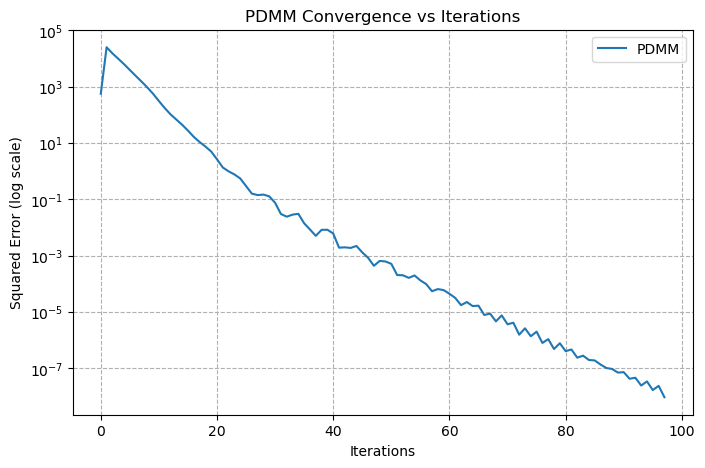

In [19]:
# ------------------ Visualization: error vs iteration ------------------
plt.figure(figsize=(8, 5))
plt.semilogy(np.arange(0, len(history_pdmm['errors'])) * log_freq, history_pdmm['errors'], label='PDMM')
plt.xlabel('Iterations')
plt.ylabel('Squared Error (log scale)')
plt.title('PDMM Convergence vs Iterations')
plt.grid(True, which='both', linestyle='--')
plt.legend()
plt.show()

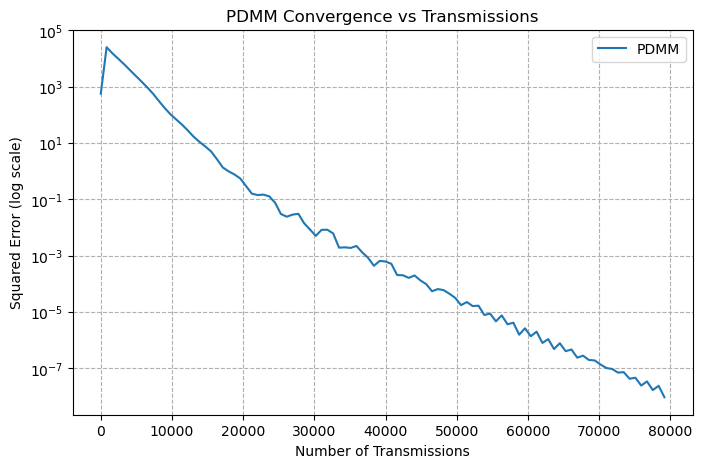

In [20]:
# ------------------ Visualization: error vs number of transmissions ------------------
plt.figure(figsize=(8, 5))
plt.semilogy(history_pdmm['tx_curve'], history_pdmm['errors'], label='PDMM')
plt.xlabel('Number of Transmissions')
plt.ylabel('Squared Error (log scale)')
plt.title('PDMM Convergence vs Transmissions')
plt.grid(True, which='both', linestyle='--')
plt.legend()
plt.show()

In [21]:
# Output total number of transmissions
print("Total number of transmissions used by PDMM:", history_pdmm['transmissions'])

Total number of transmissions used by PDMM: 79152


### Comparison between RG and PDMM

In [22]:
log_freq = 1

# run 4 results of syn unicast pdmm, asyn unicast pdmm, syn broadcast pdmm, asyn broadcast pdmm
pdmm_syn_unicast, history_pdmm_syn_unicast = pdmm_average_consensus(init_values, adj_matrix)
pdmm_asyn_unicast, history_pdmm_asyn_unicast = pdmm_average_consensus(
    init_values, adj_matrix, is_synchronous=False, active_rate=0.3)
pdmm_syn_broadcast, history_pdmm_syn_broadcast = pdmm_average_consensus(
    init_values, adj_matrix, is_unicast=False)
pdmm_asyn_broadcast, history_pdmm_asyn_broadcast = pdmm_average_consensus(
    init_values, adj_matrix, is_unicast=False, is_synchronous=False, active_rate=0.5)

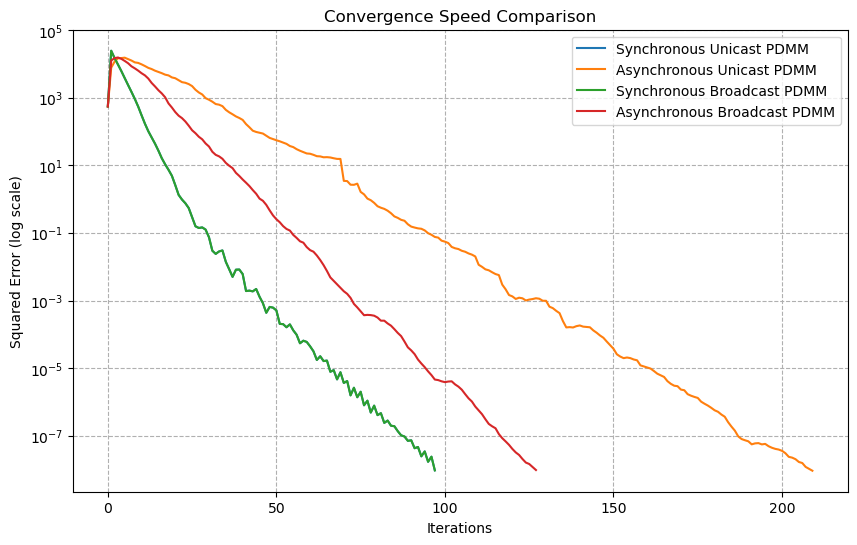

In [23]:
# generate image showing the squared error vs iteration
# the image has 5 lines, representing the results of syn unicast pdmm, asyn unicast pdmm, syn broadcast pdmm, asyn broadcast pdmm
plt.figure(figsize=(10, 6))

# Synchronous Unicast PDMM
plt.semilogy(np.arange(0, len(history_pdmm_syn_unicast['errors'])) * log_freq,
                history_pdmm_syn_unicast['errors'], label='Synchronous Unicast PDMM')

# Asynchronous Unicast PDMM
plt.semilogy(np.arange(0, len(history_pdmm_asyn_unicast['errors'])) * log_freq,
                history_pdmm_asyn_unicast['errors'], label='Asynchronous Unicast PDMM')

# Synchronous Broadcast PDMM
plt.semilogy(np.arange(0, len(history_pdmm_syn_broadcast['errors'])) * log_freq,
                history_pdmm_syn_broadcast['errors'], label='Synchronous Broadcast PDMM')

# Asynchronous Broadcast PDMM
plt.semilogy(np.arange(0, len(history_pdmm_asyn_broadcast['errors'])) * log_freq,
                history_pdmm_asyn_broadcast['errors'], label='Asynchronous Broadcast PDMM')

plt.xlabel('Iterations')
plt.ylabel('Squared Error (log scale)')
plt.title('Convergence Speed Comparison')
plt.grid(True, which="both", ls="--")
plt.legend()
# plt.savefig('error_vs_iteration_comparison.png') # Save the figure
plt.show()

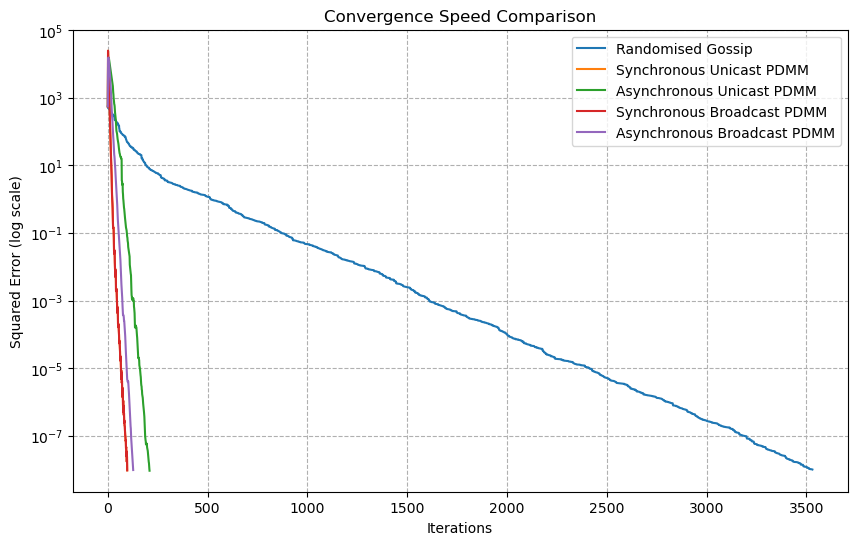

In [24]:
# generate image showing the squared error vs iteration
# the image has 5 lines, representing the results of rg, syn unicast pdmm, asyn unicast pdmm, syn broadcast pdmm, asyn broadcast pdmm
plt.figure(figsize=(10, 6))

# Randomised Gossip
plt.semilogy(np.arange(0, len(history_rg['errors'])) * log_freq, history_rg['errors'], label='Randomised Gossip')

# Synchronous Unicast PDMM
plt.semilogy(np.arange(0, len(history_pdmm_syn_unicast['errors'])) * log_freq,
                history_pdmm_syn_unicast['errors'], label='Synchronous Unicast PDMM')

# Asynchronous Unicast PDMM
plt.semilogy(np.arange(0, len(history_pdmm_asyn_unicast['errors'])) * log_freq,
                history_pdmm_asyn_unicast['errors'], label='Asynchronous Unicast PDMM')

# Synchronous Broadcast PDMM
plt.semilogy(np.arange(0, len(history_pdmm_syn_broadcast['errors'])) * log_freq,
                history_pdmm_syn_broadcast['errors'], label='Synchronous Broadcast PDMM')

# Asynchronous Broadcast PDMM
plt.semilogy(np.arange(0, len(history_pdmm_asyn_broadcast['errors'])) * log_freq,
                history_pdmm_asyn_broadcast['errors'], label='Asynchronous Broadcast PDMM')

plt.xlabel('Iterations')
plt.ylabel('Squared Error (log scale)')
plt.title('Convergence Speed Comparison')
plt.grid(True, which="both", ls="--")
plt.legend()
# plt.savefig('error_vs_iteration_comparison.png') # Save the figure
plt.show()

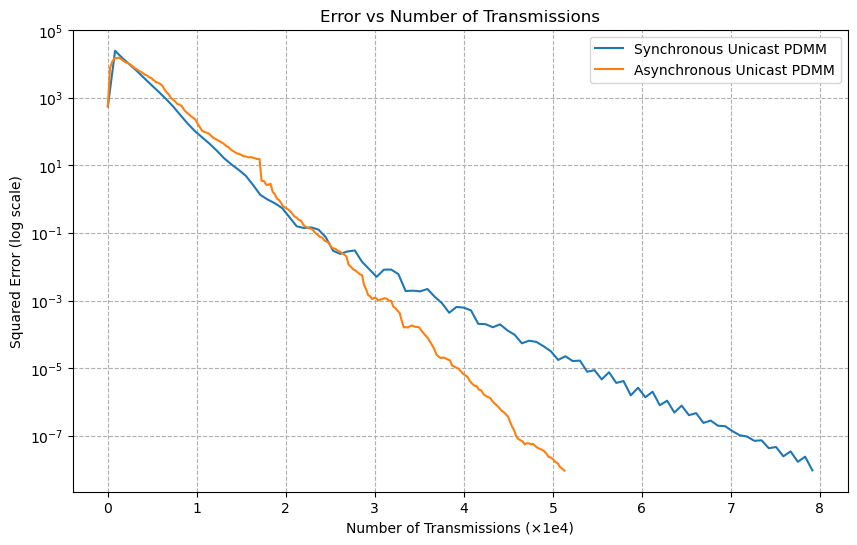

In [25]:
# generate image showing the squared error vs number of transmissions
# only the results of syn unicast pdmm, asyn unicast pdmm
plt.figure(figsize=(10, 6))
# Synchronous Unicast PDMM
plt.semilogy(np.array(history_pdmm_syn_unicast['tx_curve']) / 1e4, history_pdmm_syn_unicast['errors'], label='Synchronous Unicast PDMM')
# Asynchronous Unicast PDMM
plt.semilogy(np.array(history_pdmm_asyn_unicast['tx_curve']) / 1e4, history_pdmm_asyn_unicast['errors'], label='Asynchronous Unicast PDMM')

plt.xlabel('Number of Transmissions (×1e4)')
plt.ylabel('Squared Error (log scale)')
plt.title('Error vs Number of Transmissions')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.show()

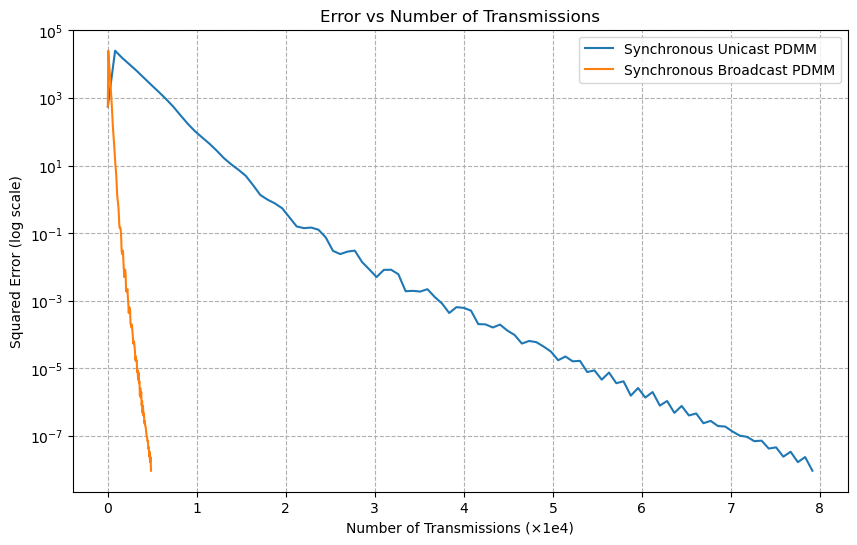

In [26]:
# generate image showing the squared error vs number of transmissions
# the image has 5 lines, only the results of syn unicast pdmm, syn broadcast pdmm
plt.figure(figsize=(10, 6))

# Synchronous Unicast PDMM
plt.semilogy(np.array(history_pdmm_syn_unicast['tx_curve']) / 1e4, history_pdmm_syn_unicast['errors'], label='Synchronous Unicast PDMM')
# Synchronous Broadcast PDMM
plt.semilogy(np.array(history_pdmm_syn_broadcast['tx_curve']) / 1e4, history_pdmm_syn_broadcast['errors'], label='Synchronous Broadcast PDMM')

plt.xlabel('Number of Transmissions (×1e4)')
plt.ylabel('Squared Error (log scale)')
plt.title('Error vs Number of Transmissions')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.show()

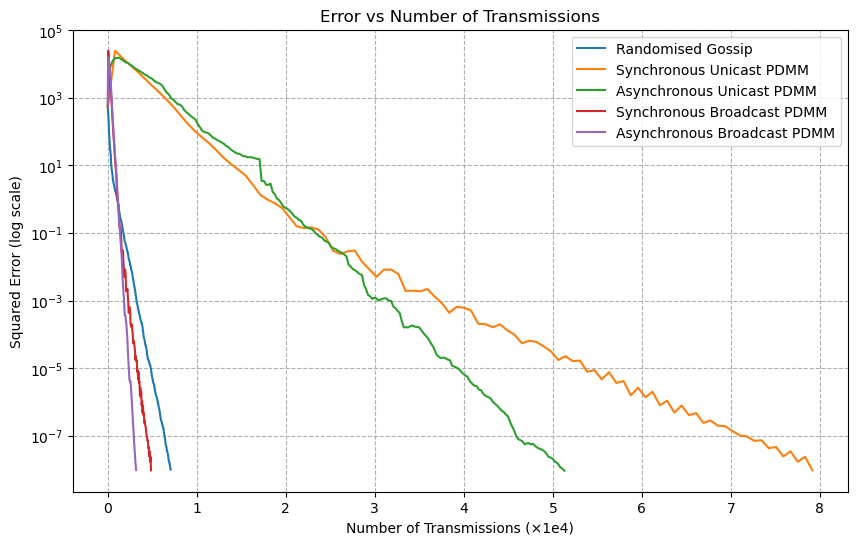

In [27]:
# generate image showing the squared error vs number of transmissions
plt.figure(figsize=(10, 6))
# Randomised Gossip
plt.semilogy(np.arange(0, len(history_rg['errors'])) * log_freq * 2 / 1e4, history_rg['errors'], label='Randomised Gossip')
# Synchronous Unicast PDMM
plt.semilogy(np.array(history_pdmm_syn_unicast['tx_curve']) / 1e4, history_pdmm_syn_unicast['errors'], label='Synchronous Unicast PDMM')
# Asynchronous Unicast PDMM
plt.semilogy(np.array(history_pdmm_asyn_unicast['tx_curve']) / 1e4, history_pdmm_asyn_unicast['errors'], label='Asynchronous Unicast PDMM')
# Synchronous Broadcast PDMM
plt.semilogy(np.array(history_pdmm_syn_broadcast['tx_curve']) / 1e4, history_pdmm_syn_broadcast['errors'], label='Synchronous Broadcast PDMM')
# Asynchronous Broadcast PDMM
plt.semilogy(np.array(history_pdmm_asyn_broadcast['tx_curve']) / 1e4, history_pdmm_asyn_broadcast['errors'], label='Asynchronous Broadcast PDMM')

plt.xlabel('Number of Transmissions (×1e4)')
plt.ylabel('Squared Error (log scale)')
plt.title('Error vs Number of Transmissions')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.show()

## Q3 median

In [28]:
"""
Synchronous PDMM for the median-consensus problem.

Returns
-------
x : np.ndarray
    Consensus values at each node.
history : dict
    'errors'          squared-error trace ‖x-median‖² every log_freq iters
    'abs_errors'      absolute-error trace ‖x-median‖ every log_freq iters
    'tx_curve'        cumulative number of scalar transmissions
    'transmissions'   final total transmissions
"""
def pdmm_median_consensus(
        v,               # Local sensor readings a_i
        adj,             # Adjacency matrix (bool 2-D)
        c=1.0,           # PDMM tuning parameter c
        is_unicast=True,  # whether to use unicast or broadcast
        is_synchronous=True,  # whether to use synchronous or asynchronous PDMM
        active_rate=1.0,  # active nodes rate in asynchronous mode
        max_iter=5000,
        tol=1e-8,
        log_freq=10,
        verbose=False):
    
    n = len(v)
    deg = np.sum(adj, axis=1)            # Node degree d_i
    median = np.median(v)

    # ---------- Initialisation ----------
    # Directed edge set: (i, j) s.t. i ≠ j and adj[i, j] == True
    dir_edges = [(i, j) for i in range(n) for j in range(n)
                 if i != j and adj[i, j]]
    z = {e: 0.0 for e in dir_edges}        # z_{i|j}
    x = v.copy()

    # ---------- Logging ----------
    err_hist = [np.sum((x - median) ** 2)]
    abs_err_hist = [np.linalg.norm(x - median)]
    tx_hist  = [0]
    transmissions = 0
    # iterations = 0

    # ---------- Main loop ----------
    for k in range(1, max_iter):
        # according to is_synchronous, iterate over all nodes or just some random ones
        if is_synchronous:
            active_nodes = range(n)
        else:
            active_nodes = random.sample(range(n), int(active_rate * n))

        y = {}
        for i in active_nodes:
            neighbors = [j for (k, j) in dir_edges if k == i]
            if not neighbors:
                continue
            
            s_z = 0
            for j in neighbors:
                A = 1 if i < j else -1
                s_z += A * z[(i, j)]
            
            # 1) x-update
            denominator = c * deg[i]
            bound_low = (-1 - s_z) / denominator
            bound_high = (1 - s_z) / denominator
            if bound_low > v[i]:
                x[i] = bound_low
            elif bound_high < v[i]:
                x[i] = bound_high
            else:
                x[i] = v[i]

            # 2) y-updates
            for j in neighbors:
                A = 1 if i < j else -1
                y[(i, j)] = z[(i, j)] + 2 * c * A * x[i]

            if is_unicast:
                # Unicast: send y_{i|j} to j
                transmissions += len(neighbors)
            else:
                # Broadcast: send x_{k} to j
                transmissions += 1

        # 3) z-updates
        for i in active_nodes:
            for j in range(n):
                if i != j and adj[i, j]:
                    z[(j, i)] = 0.5 * z[(j, i)] + 0.5 * y[(i, j)] # z_{i|j}^{(k+1)}

        # Logging / convergence check
        # if k % log_freq == 0:
        err = np.sum((x - median) ** 2)
        err_hist.append(err)
        abs_err = np.linalg.norm(x - median)
        abs_err_hist.append(abs_err)
        tx_hist.append(transmissions)
        if verbose:
            print(f"iter {k:5d} | err = {err:.3e}")
        if err < tol:
            break

    history = {
        'errors': err_hist,
        'abs_errors': abs_err_hist,
        'tx_curve': tx_hist,
        'transmissions': tx_hist[-1],
        'iteration': k
    }
    
    return x, history

### Even number of nodes

In [29]:
# ------ Run PDMM with timing ------
start_time = time.time()
final_pdmm, history_pdmm = pdmm_median_consensus(init_values, adj_matrix)
elapsed_time = time.time() - start_time

# ------ Postprocessing metrics ------
final_values = final_pdmm
final_median = np.median(final_values)
global_median = np.median(init_values)
final_error = history_pdmm['errors'][-1]         # last squared error

# ------ Output results ------
print("\nAlgorithm completed!")
print(f"Total iterations: {len(history_pdmm['errors'])}")
print(f"Total transmissions: {history_pdmm['transmissions']}")
print(f"Execution time: {elapsed_time:.4f} seconds")
print(f"Final estimated average: {final_median:.8f}")
print(f"Global average: {global_median:.8f}")
print(f"Absolute error: {abs(final_median - global_median):.8f}")
print(f"Squared error: {final_error:.8f}")


Algorithm completed!
Total iterations: 5000
Total transmissions: 4079184
Execution time: 12.0087 seconds
Final estimated average: 24.94198615
Global average: 24.94961035
Absolute error: 0.00762419
Squared error: 0.00290642


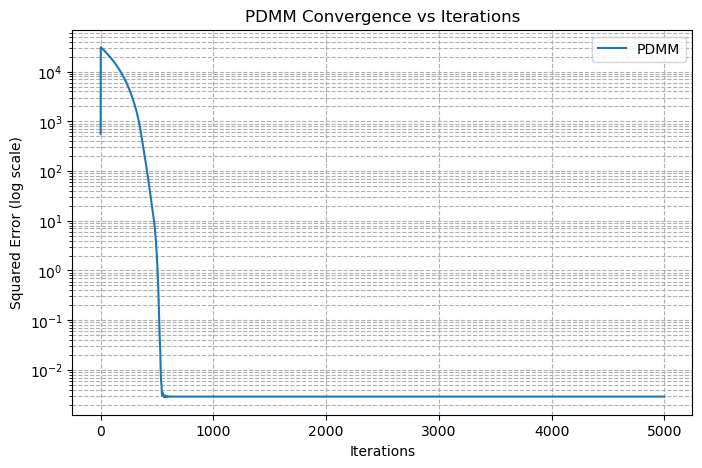

In [30]:
# ------------------ Visualization: error vs iteration ------------------
plt.figure(figsize=(8, 5))
plt.semilogy(np.arange(0, len(history_pdmm['errors'])), history_pdmm['errors'], label='PDMM')
plt.xlabel('Iterations')
plt.ylabel('Squared Error (log scale)')
plt.title('PDMM Convergence vs Iterations')
plt.grid(True, which='both', linestyle='--')
plt.legend()
plt.show()

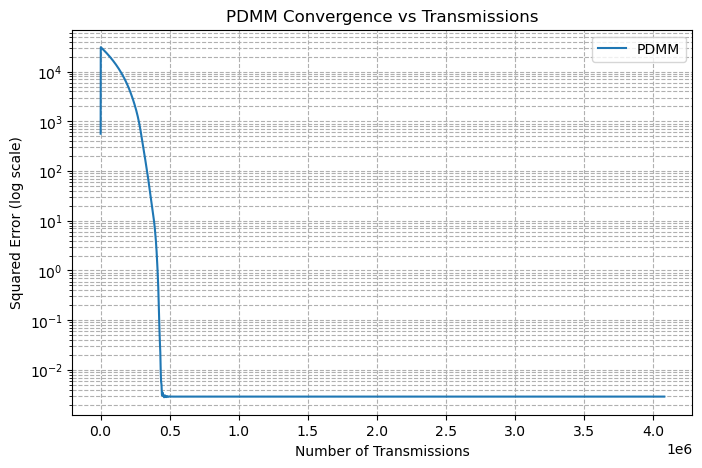

In [31]:
# ------------------ Visualization: error vs number of transmissions ------------------
plt.figure(figsize=(8, 5))
plt.semilogy(history_pdmm['tx_curve'], history_pdmm['errors'], label='PDMM')
plt.xlabel('Number of Transmissions')
plt.ylabel('Squared Error (log scale)')
plt.title('PDMM Convergence vs Transmissions')
plt.grid(True, which='both', linestyle='--')
plt.legend()
plt.show()

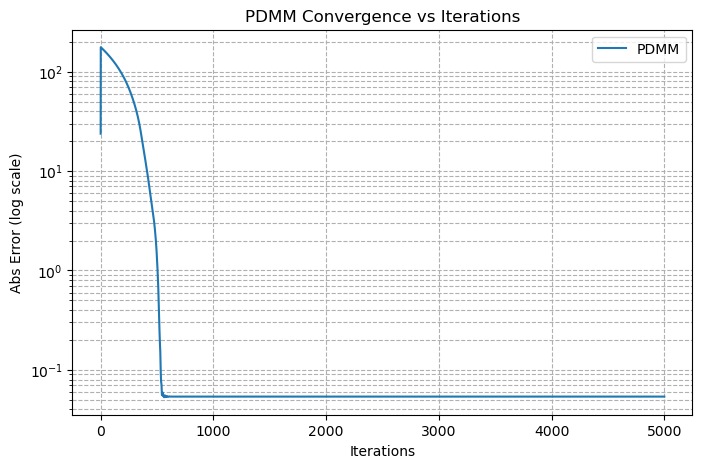

In [32]:
# ------------------ Visualization: error vs iteration ------------------
plt.figure(figsize=(8, 5))
plt.semilogy(np.arange(0, len(history_pdmm['abs_errors'])), history_pdmm['abs_errors'], label='PDMM')
plt.xlabel('Iterations')
plt.ylabel('Abs Error (log scale)')
plt.title('PDMM Convergence vs Iterations')
plt.grid(True, which='both', linestyle='--')
plt.legend()
plt.show()

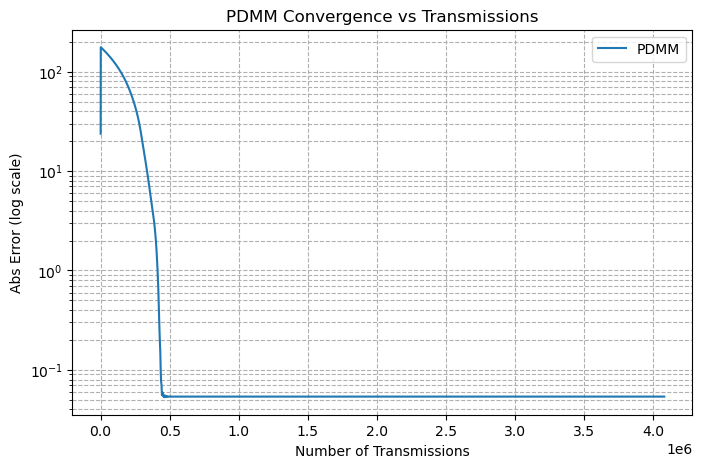

In [33]:
# ------------------ Visualization: error vs number of transmissions ------------------
plt.figure(figsize=(8, 5))
plt.semilogy(history_pdmm['tx_curve'], history_pdmm['abs_errors'], label='PDMM')
plt.xlabel('Number of Transmissions')
plt.ylabel('Abs Error (log scale)')
plt.title('PDMM Convergence vs Transmissions')
plt.grid(True, which='both', linestyle='--')
plt.legend()
plt.show()

### Comparison between different PDMM

In [34]:
pdmm_syn_unicast, history_pdmm_syn_unicast = pdmm_median_consensus(init_values, adj_matrix)
pdmm_asyn_unicast, history_pdmm_asyn_unicast = pdmm_median_consensus(
    init_values, adj_matrix, is_synchronous=False, active_rate=0.5)
pdmm_syn_broadcast, history_pdmm_syn_broadcast = pdmm_median_consensus(
    init_values, adj_matrix, is_unicast=False)
pdmm_asyn_broadcast, history_pdmm_asyn_broadcast = pdmm_median_consensus(
    init_values, adj_matrix, is_unicast=False, is_synchronous=False, active_rate=0.5)

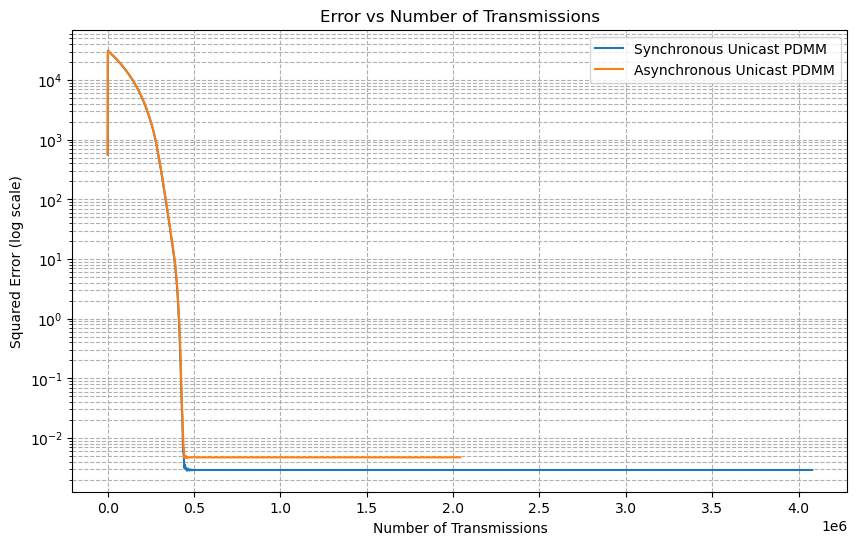

In [35]:
# generate image showing the squared error vs number of transmissions
# only the results of syn unicast pdmm, asyn unicast pdmm
plt.figure(figsize=(10, 6))
# Synchronous Unicast PDMM
plt.semilogy(np.array(history_pdmm_syn_unicast['tx_curve']), history_pdmm_syn_unicast['errors'], label='Synchronous Unicast PDMM')
# Asynchronous Unicast PDMM
plt.semilogy(np.array(history_pdmm_asyn_unicast['tx_curve']), history_pdmm_asyn_unicast['errors'], label='Asynchronous Unicast PDMM')

plt.xlabel('Number of Transmissions')
plt.ylabel('Squared Error (log scale)')
plt.title('Error vs Number of Transmissions')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.show()

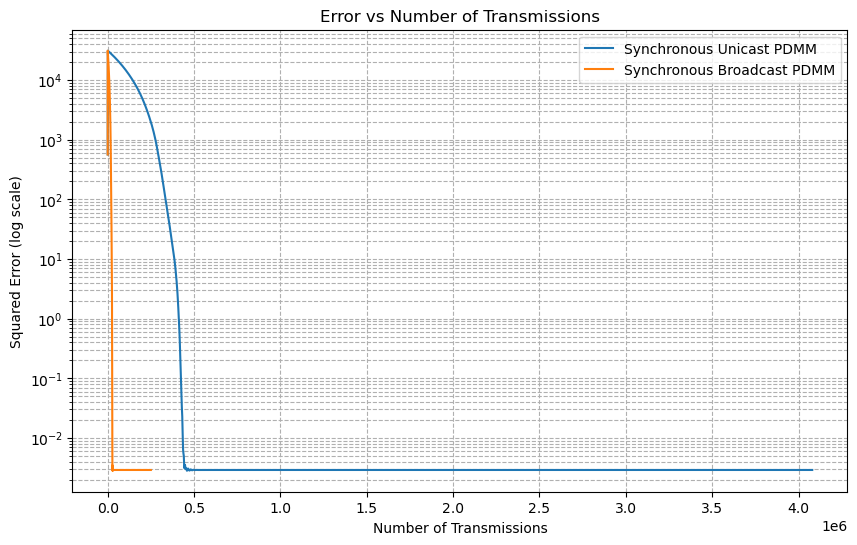

In [36]:
# generate image showing the squared error vs number of transmissions
# the image has 5 lines, only the results of syn unicast pdmm, syn broadcast pdmm
plt.figure(figsize=(10, 6))

# Synchronous Unicast PDMM
plt.semilogy(np.array(history_pdmm_syn_unicast['tx_curve']), history_pdmm_syn_unicast['errors'], label='Synchronous Unicast PDMM')
# Synchronous Broadcast PDMM
plt.semilogy(np.array(history_pdmm_syn_broadcast['tx_curve']), history_pdmm_syn_broadcast['errors'], label='Synchronous Broadcast PDMM')

plt.xlabel('Number of Transmissions')
plt.ylabel('Squared Error (log scale)')
plt.title('Error vs Number of Transmissions')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.show()

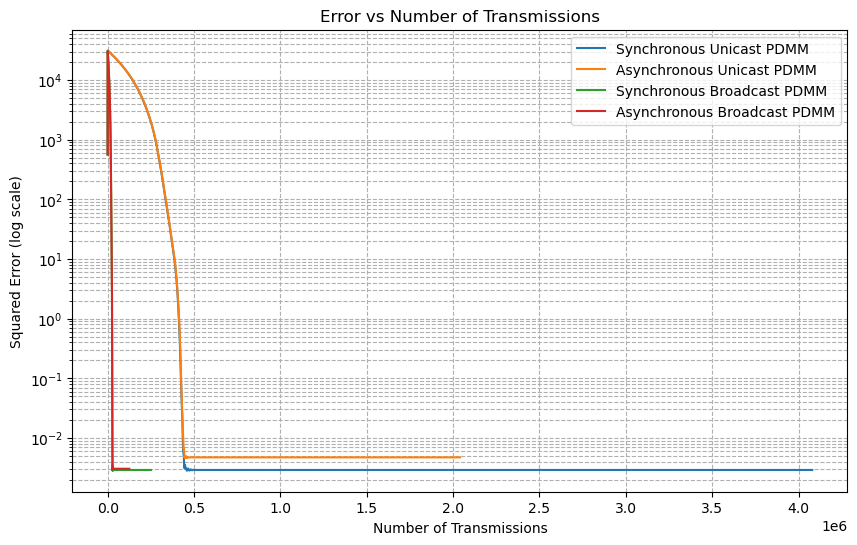

In [37]:
# generate image showing the squared error vs number of transmissions
plt.figure(figsize=(10, 6))
# Synchronous Unicast PDMM
plt.semilogy(np.array(history_pdmm_syn_unicast['tx_curve']), history_pdmm_syn_unicast['errors'], label='Synchronous Unicast PDMM')
# Asynchronous Unicast PDMM
plt.semilogy(np.array(history_pdmm_asyn_unicast['tx_curve']), history_pdmm_asyn_unicast['errors'], label='Asynchronous Unicast PDMM')
# Synchronous Broadcast PDMM
plt.semilogy(np.array(history_pdmm_syn_broadcast['tx_curve']), history_pdmm_syn_broadcast['errors'], label='Synchronous Broadcast PDMM')
# Asynchronous Broadcast PDMM
plt.semilogy(np.array(history_pdmm_asyn_broadcast['tx_curve']), history_pdmm_asyn_broadcast['errors'], label='Asynchronous Broadcast PDMM')

plt.xlabel('Number of Transmissions')
plt.ylabel('Squared Error (log scale)')
plt.title('Error vs Number of Transmissions')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.show()

### Odd number of nodes

In [40]:
np.random.seed(42)
random.seed(42)
Area_Coverage = 0.999
Connected_Prob = 0.99

n = 51 # Number of sensors
Comm_Radius = 40 # Communication radius of each sensor

sensor_location = np.random.uniform(0, Area_Length, (n, 2))

# Calculate Euclidean distance matrix
Euc_matrix = distance_matrix(sensor_location, sensor_location)

# Calculate adjacency matrix
adj_matrix_51 = (Euc_matrix <= Comm_Radius) & (Euc_matrix > 0)
print(adj_matrix_51)

# Build network graph
Graphs = nx.Graph()
for i in range(n):
    Graphs.add_node(i, pos = tuple(sensor_location[i]))

for j in range(n):
    for k in range (j+1, n):
        if adj_matrix_51[j,k]:
            Graphs.add_edge(j, k)
print(f"Network connected: {nx.is_connected(Graphs)}")
print(f"Number of edges: {Graphs.number_of_edges()}")

# init_values = np.random.uniform(10, 20, n)
init_values_51 = np.random.normal(loc=25, scale=3, size=n)
global_median_51 = np.median(init_values_51)
print(f"Global average: {global_median_51:.4f}")

[[False False False ... False False False]
 [False False False ...  True False False]
 [False False False ... False  True False]
 ...
 [False  True False ... False False False]
 [False False  True ... False False False]
 [False False False ... False False False]]
Network connected: True
Number of edges: 411
Global average: 24.9205


In [41]:
# ------ Run PDMM with timing ------
start_time = time.time()
final_pdmm, history_pdmm = pdmm_median_consensus(init_values_51, adj_matrix_51)
elapsed_time = time.time() - start_time

# ------ Postprocessing metrics ------
final_values = final_pdmm
final_median = np.median(final_values)
global_median = np.median(init_values_51)
final_error = history_pdmm['errors'][-1]         # last squared error

# ------ Output results ------
print("\nAlgorithm completed!")
print(f"Total iterations: {len(history_pdmm['errors'])}")
print(f"Total transmissions: {history_pdmm['transmissions']}")
print(f"Execution time: {elapsed_time:.4f} seconds")
print(f"Final estimated average: {final_median:.8f}")
print(f"Global average: {global_median:.8f}")
print(f"Absolute error: {abs(final_median - global_median):.8f}")
print(f"Squared error: {final_error:.8f}")


Algorithm completed!
Total iterations: 1057
Total transmissions: 868032
Execution time: 2.4803 seconds
Final estimated average: 24.92045941
Global average: 24.92045837
Absolute error: 0.00000103
Squared error: 0.00000000


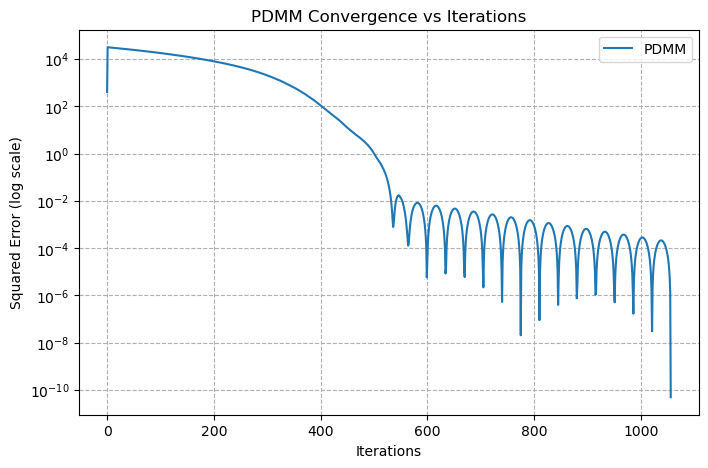

In [42]:
# ------------------ Visualization: error vs iteration ------------------
plt.figure(figsize=(8, 5))
plt.semilogy(np.arange(0, len(history_pdmm['errors'])), history_pdmm['errors'], label='PDMM')
plt.xlabel('Iterations')
plt.ylabel('Squared Error (log scale)')
plt.title('PDMM Convergence vs Iterations')
plt.grid(True, which='both', linestyle='--')
plt.legend()
plt.show()

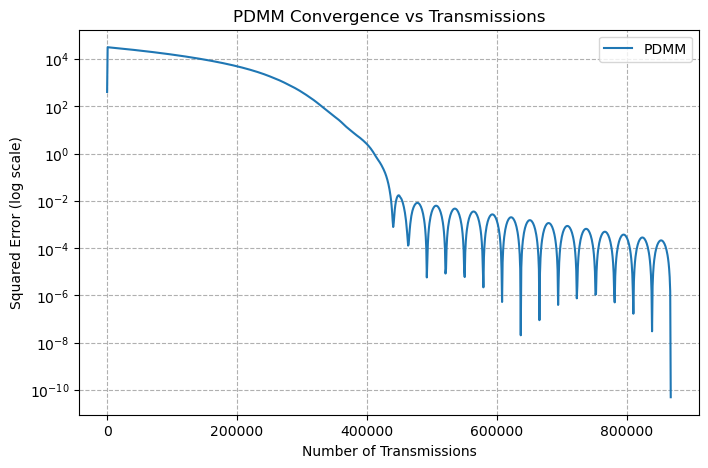

In [43]:
# ------------------ Visualization: error vs number of transmissions ------------------
plt.figure(figsize=(8, 5))
plt.semilogy(history_pdmm['tx_curve'], history_pdmm['errors'], label='PDMM')
plt.xlabel('Number of Transmissions')
plt.ylabel('Squared Error (log scale)')
plt.title('PDMM Convergence vs Transmissions')
plt.grid(True, which='both', linestyle='--')
plt.legend()
plt.show()

### Comparison between different PDMM

In [44]:
pdmm_syn_unicast, history_pdmm_syn_unicast = pdmm_median_consensus(init_values_51, adj_matrix_51)
pdmm_asyn_unicast, history_pdmm_asyn_unicast = pdmm_median_consensus(
    init_values_51, adj_matrix_51, is_synchronous=False, active_rate=0.5)
pdmm_syn_broadcast, history_pdmm_syn_broadcast = pdmm_median_consensus(
    init_values_51, adj_matrix_51, is_unicast=False)
pdmm_asyn_broadcast, history_pdmm_asyn_broadcast = pdmm_median_consensus(
    init_values_51, adj_matrix_51, is_unicast=False, is_synchronous=False, active_rate=0.5)

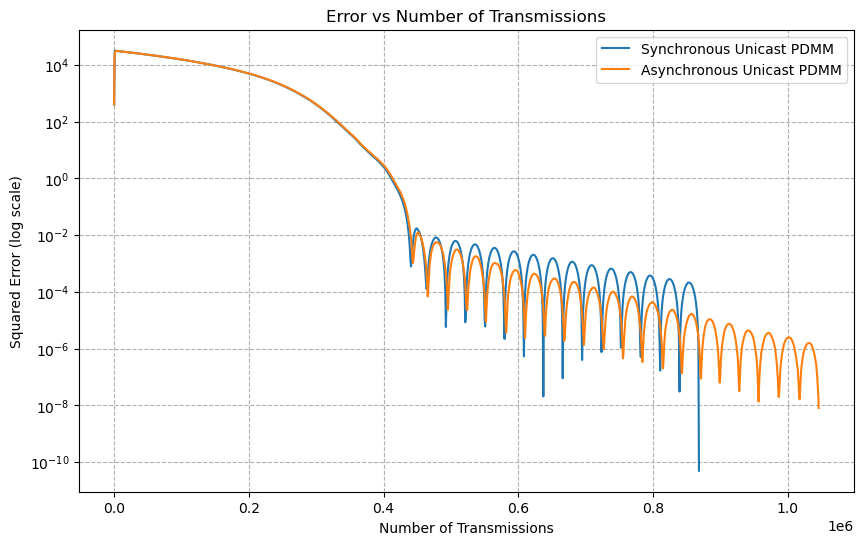

In [45]:
# generate image showing the squared error vs number of transmissions
# only the results of syn unicast pdmm, asyn unicast pdmm
plt.figure(figsize=(10, 6))
# Synchronous Unicast PDMM
plt.semilogy(np.array(history_pdmm_syn_unicast['tx_curve']), history_pdmm_syn_unicast['errors'], label='Synchronous Unicast PDMM')
# Asynchronous Unicast PDMM
plt.semilogy(np.array(history_pdmm_asyn_unicast['tx_curve']), history_pdmm_asyn_unicast['errors'], label='Asynchronous Unicast PDMM')

plt.xlabel('Number of Transmissions')
plt.ylabel('Squared Error (log scale)')
plt.title('Error vs Number of Transmissions')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.show()

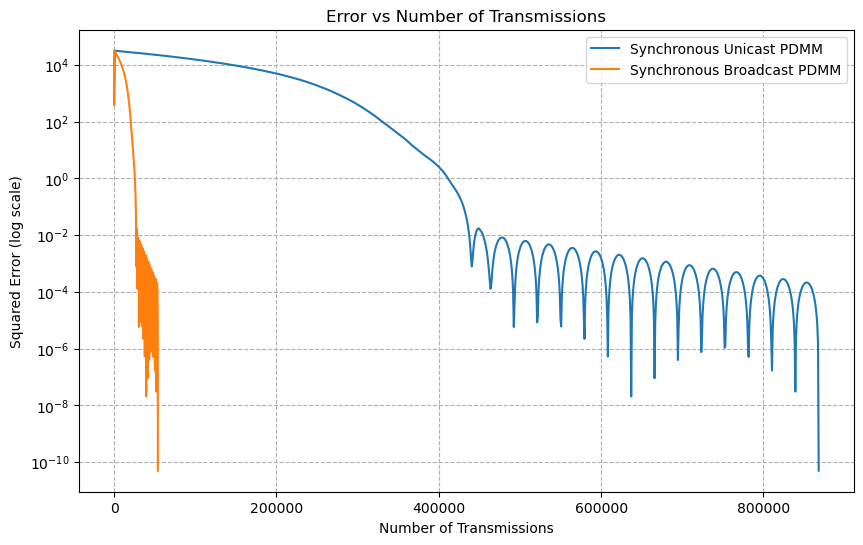

In [46]:
# generate image showing the squared error vs number of transmissions
# the image has 5 lines, only the results of syn unicast pdmm, syn broadcast pdmm
plt.figure(figsize=(10, 6))

# Synchronous Unicast PDMM
plt.semilogy(np.array(history_pdmm_syn_unicast['tx_curve']), history_pdmm_syn_unicast['errors'], label='Synchronous Unicast PDMM')
# Synchronous Broadcast PDMM
plt.semilogy(np.array(history_pdmm_syn_broadcast['tx_curve']), history_pdmm_syn_broadcast['errors'], label='Synchronous Broadcast PDMM')

plt.xlabel('Number of Transmissions')
plt.ylabel('Squared Error (log scale)')
plt.title('Error vs Number of Transmissions')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.show()

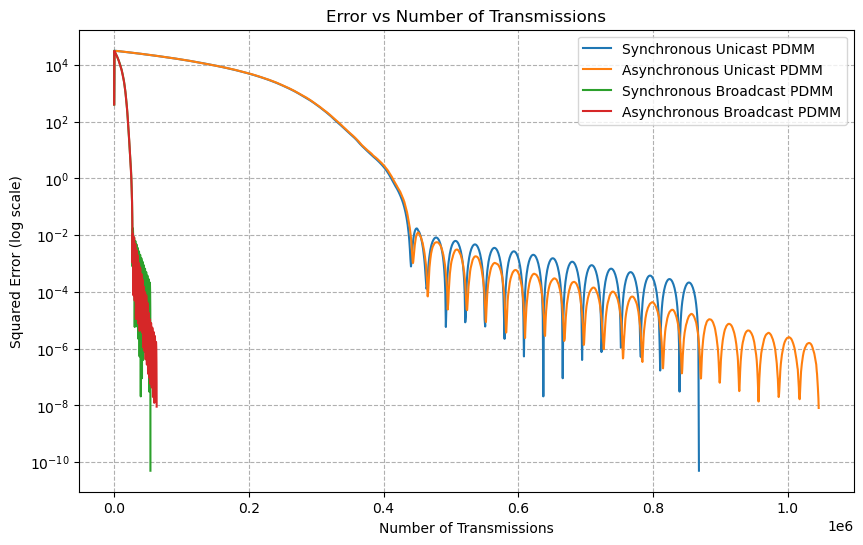

In [47]:
# generate image showing the squared error vs number of transmissions
plt.figure(figsize=(10, 6))
# Synchronous Unicast PDMM
plt.semilogy(np.array(history_pdmm_syn_unicast['tx_curve']), history_pdmm_syn_unicast['errors'], label='Synchronous Unicast PDMM')
# Asynchronous Unicast PDMM
plt.semilogy(np.array(history_pdmm_asyn_unicast['tx_curve']), history_pdmm_asyn_unicast['errors'], label='Asynchronous Unicast PDMM')
# Synchronous Broadcast PDMM
plt.semilogy(np.array(history_pdmm_syn_broadcast['tx_curve']), history_pdmm_syn_broadcast['errors'], label='Synchronous Broadcast PDMM')
# Asynchronous Broadcast PDMM
plt.semilogy(np.array(history_pdmm_asyn_broadcast['tx_curve']), history_pdmm_asyn_broadcast['errors'], label='Asynchronous Broadcast PDMM')

plt.xlabel('Number of Transmissions')
plt.ylabel('Squared Error (log scale)')
plt.title('Error vs Number of Transmissions')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.show()